In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [22]:
import numpy as np
import pylab as plt

from astropy.stats import sigma_clip

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from utils.utils import midPoint, stride, rolling_std
from zernikies import getZernikeCoeffs, getZernikeCoeffsOLS
from plotting import barChartPlot, surfacePlot
from lassiAnalysis import loadLeicaData, maskXYZ, extractZernikesLeicaScanPair

In [38]:
n = 512
nZern = 36
sigma = 13
maskRadius = 45
guess = [60., 0, 0, -50., 0, 0]
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [39]:
scans = [['2020_03_16_02:21:06.ptx.csv', '2020_03_16_02:28:31.ptx.csv'],
         ['2020_03_16_02:54:59.ptx.csv', '2020_03_16_03:02:51.ptx.csv'],
         ['2020_03_16_06:35:42.ptx.csv', '2020_03_16_06:43:17.ptx.csv']
        ]

In [40]:
diffArr = np.ma.zeros((len(scans), 3, n, n), dtype=np.float)
diffArr = np.ma.masked_invalid(diffArr)

In [41]:
%%time
for i, scan in enumerate(scans):
    refScanFile = "{}/{}".format(scanDir, scan[0])
    sigScanFile = "{}/{}".format(scanDir, scan[1])
    x,y,dz,fl = extractZernikesLeicaScanPair(refScanFile, sigScanFile, n=n, nZern=nZern, 
                                                 pFitGuess=guess, rMaskRadius=maskRadius,
                                                 **{'sigma':sigma}, verbose=True)
    diffArr[i] = x, y, dz
    diffArr[i,2].mask = dz.mask

Masking file: /home/scratch/psalas/LASSI/gpus/output//2020_03_16_02:21:06.ptx.csv
Masking file: /home/scratch/psalas/LASSI/gpus/output//2020_03_16_02:28:31.ptx.csv
Computing Zernike coefficients.
Masking file: /home/scratch/psalas/LASSI/gpus/output//2020_03_16_02:54:59.ptx.csv
Masking file: /home/scratch/psalas/LASSI/gpus/output//2020_03_16_03:02:51.ptx.csv
Computing Zernike coefficients.
Masking file: /home/scratch/psalas/LASSI/gpus/output//2020_03_16_06:35:42.ptx.csv
Masking file: /home/scratch/psalas/LASSI/gpus/output//2020_03_16_06:43:17.ptx.csv
Computing Zernike coefficients.
CPU times: user 7min 48s, sys: 6min 32s, total: 14min 21s
Wall time: 1min 14s


In [42]:
rms = np.nanstd(diffArr[:,2,:,:], axis=(1,2))
avgScan = np.average(diffArr, axis=0, weights=np.power(rms, -2.))
avgScan = np.ma.masked_invalid(avgScan)

<IPython.core.display.Javascript object>


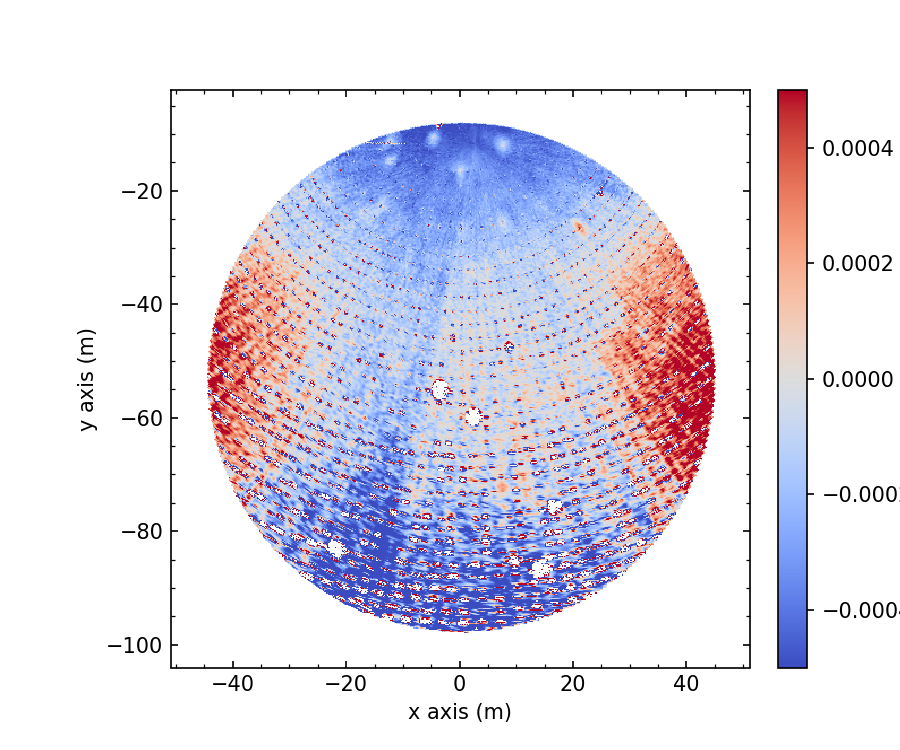

In [43]:
surfacePlot(avgScan[0], avgScan[1], sigma_clip(avgScan[2], sigma=5), vMin=-5e-4, vMax=5e-4)

<IPython.core.display.Javascript object>


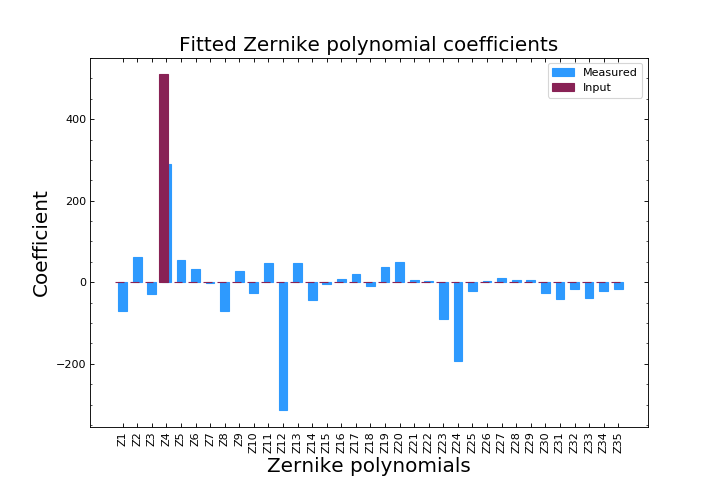

<IPython.core.display.Javascript object>


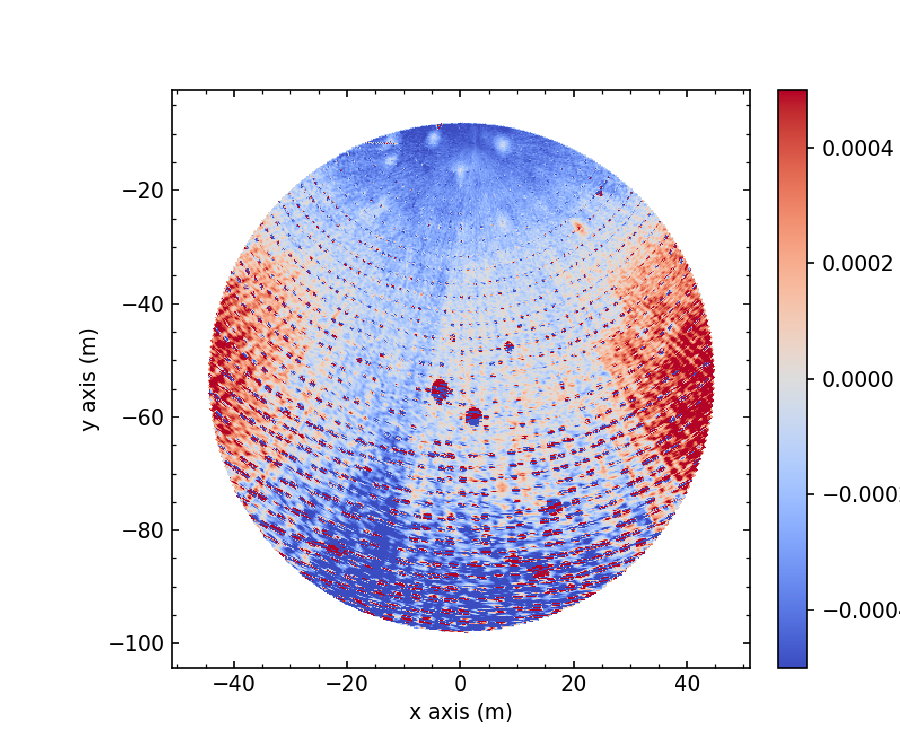

In [44]:
fl = getZernikeCoeffs((sigma_clip(avgScan[2], sigma=5)).filled(0), 36, norm='active-surface')
expected = np.zeros(36)
expected[4] = 510.
barChartPlot(np.arange(1,36), np.asarray(fl[1:36])*1e6, expected=expected[1:36])
surfacePlot(x, y, avgScan[2], vMin=-5e-4, vMax=5e-4)

/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in power
  """


<IPython.core.display.Javascript object>


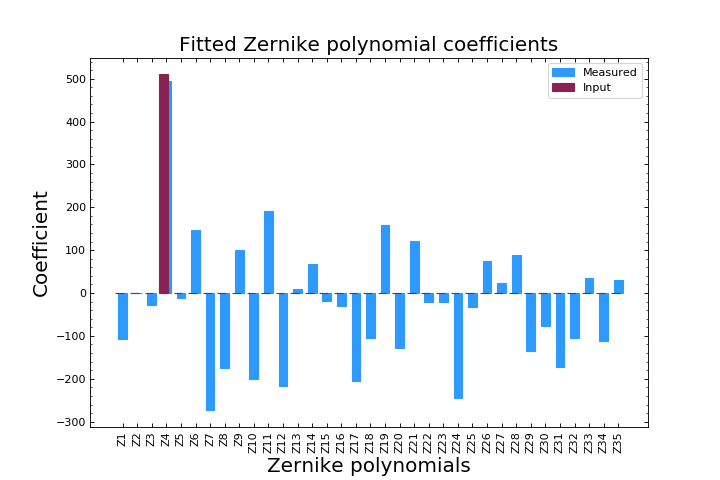

In [45]:
dz_s = stride(avgScan[2].filled(np.nan), r_c=(4,4))
dz_std = rolling_std(dz_s, no_null=False)
dz_std_pad = np.pad(dz_std, ((2,1),(2,1)), mode='constant', constant_values=np.nan)
dz_std_pad = np.ma.masked_where(dz_std_pad <= 20e-6, dz_std_pad)
w = np.power(dz_std_pad, -2.)
coefs = getZernikeCoeffsOLS(avgScan[0]-midPoint(avgScan[0]), avgScan[1]-midPoint(avgScan[1]), avgScan[2], 36, weights=w)
barChartPlot(np.arange(1,36), coefs[1:36]*1e6, expected=expected[1:36])